# Import libraries

In [1]:
pip install optbinning

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import chi2_contingency
from sklearn.tree import plot_tree
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from optbinning import OptimalBinning

(CVXPY) Mar 28 12:27:05 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 28 12:27:05 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


# Import & preparing datasets


In [3]:
# load the customer datasets
df_ecommerce = pd.read_excel('Data.xlsx')
df_ecommerce.head()

,Order_status,Order_date,Delivered_date,Promised_delivery_date,Seller_transfer_date,Call_for_delivery,Payment_type,Payment_value,Price,Shipping_fee,Is_freeship,Business_Unit,Product_name_length,Product_description_length,Product_photos_qty,Review_score,Delivery_days,Estimated_days,Shipping_days,Payment_to_price
0,delivered,2017-10-02,2017-10-03 14:24:00,2017-10-05 04:48:00,2017-10-02 19:12:00,1 times,Credit Card,12080.000000,59980.0,872.0,Freeship,MP,40,268,4,4,1.6,3.2,0.8,0.201400
1,delivered,2017-10-02,2017-10-03 14:24:00,2017-10-05 04:48:00,2017-10-02 19:12:00,2 times,COD,1333.333333,59980.0,872.0,Freeship,MP,40,268,4,4,1.6,3.2,0.8,0.022230
2,delivered,2017-10-02,2017-10-03 14:24:00,2017-10-05 04:48:00,2017-10-02 19:12:00,2 times,COD,12393.333333,59980.0,872.0,Freeship,MP,40,268,4,4,1.6,3.2,0.8,0.206624
3,delivered,2018-07-24,2018-07-26 19:12:00,2018-07-28 00:00:00,2018-07-25 04:48:00,1 times,COD,94306.666667,237400.0,2276.0,Non_Freeship,Lazmall,29,178,1,4,2.8,4.0,1.2,0.397248
4,delivered,2018-08-08,2018-08-09 19:12:00,2018-08-13 09:36:00,2018-08-09 00:00:00,2 times,Credit Card,119413.333333,319800.0,1922.0,Non_Freeship,MP,46,232,1,5,1.8,5.4,1.0,0.373400


In [4]:
df_ecommerce

,Order_status,Order_date,Delivered_date,Promised_delivery_date,Seller_transfer_date,Call_for_delivery,Payment_type,Payment_value,Price,Shipping_fee,Is_freeship,Business_Unit,Product_name_length,Product_description_length,Product_photos_qty,Review_score,Delivery_days,Estimated_days,Shipping_days,Payment_to_price
0,delivered,2017-10-02,2017-10-03 14:24:00,2017-10-05 04:48:00,2017-10-02 19:12:00,1 times,Credit Card,12080.000000,59980.0,872.0,Freeship,MP,40,268,4,4,1.6,3.2,0.8,0.201400
1,delivered,2017-10-02,2017-10-03 14:24:00,2017-10-05 04:48:00,2017-10-02 19:12:00,2 times,COD,1333.333333,59980.0,872.0,Freeship,MP,40,268,4,4,1.6,3.2,0.8,0.022230
2,delivered,2017-10-02,2017-10-03 14:24:00,2017-10-05 04:48:00,2017-10-02 19:12:00,2 times,COD,12393.333333,59980.0,872.0,Freeship,MP,40,268,4,4,1.6,3.2,0.8,0.206624
3,delivered,2018-07-24,2018-07-26 19:12:00,2018-07-28 00:00:00,2018-07-25 04:48:00,1 times,COD,94306.666667,237400.0,2276.0,Non_Freeship,Lazmall,29,178,1,4,2.8,4.0,1.2,0.397248
4,delivered,2018-08-08,2018-08-09 19:12:00,2018-08-13 09:36:00,2018-08-09 00:00:00,2 times,Credit Card,119413.333333,319800.0,1922.0,Non_Freeship,MP,46,232,1,5,1.8,5.4,1.0,0.373400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113204,delivered,2018-02-06,2018-02-10 09:36:00,2018-02-10 19:12:00,2018-02-07 04:48:00,1 times,Credit Card,130000.000000,349800.0,2010.0,Non_Freeship,MP,52,828,4,4,4.4,4.8,1.2,0.371641
113205,delivered,2017-08-27,2017-09-01 00:00:00,2017-09-02 04:48:00,2017-08-28 19:12:00,1 times,Credit Card,180673.333333,411980.0,6502.0,Non_Freeship,LazGlobal,51,500,2,5,5.0,6.2,1.8,0.438549
113206,delivered,2018-01-08,2018-01-11 09:36:00,2018-01-15 14:24:00,2018-01-08 19:12:00,1 times,Credit Card,294106.666667,359980.0,4059.0,Non_Freeship,LazGlobal,59,1893,1,2,3.4,7.6,0.8,0.817008
113207,delivered,2018-01-08,2018-01-11 09:36:00,2018-01-15 14:24:00,2018-01-08 19:12:00,1 times,Credit Card,294106.666667,359980.0,4059.0,Non_Freeship,LazGlobal,59,1893,1,2,3.4,7.6,0.8,0.817008


1. **Order_status**: This is a reference to the order status (delivered or canceled).
2. **Order_date**: Displays the timestamp of each item's purchase.
3. **Delivered_date**: Displays the customer's actual order delivery date.
4. **Promised_delivery_date**: Displays the estimated delivery date that was provided to the customer at the time of purchase.
5. **Seller_transfer_date**: Displays the seller's shipping limit date for transferring the order to the logistic partner.
6. **Call_for_delivery**: 
7. **Payment_type**: The customer's preferred method of payment.
8. **Payment_value**: The transaction's value.
9. **Is_freeship**: Is freeship or not.
10. **Price**: The cost of each item.
11. **Shipping_fee**: The cost of transportation for each item (if an order has more than one item the freight value is split between items).
12. **Business_Unit**: Business Units.
13. **Product_name_length**: The number of characters extracted from the product name.
14. **Product_description_length**: The number of characters extracted from the product description.
15. **Product_photos_qty**: The number of product photos that have been published.
16. **Review_score**: A rating given by a customer on a satisfaction survey ranging from 1 to 5.

# Data cleaning & preprocessing

In [5]:
#Detecting every NaN value on every columns
df_ecommerce.isnull().sum()

Order_status                  0
Order_date                    0
Delivered_date                0
Promised_delivery_date        0
Seller_transfer_date          0
Call_for_delivery             0
Payment_type                  0
Payment_value                 0
Price                         0
Shipping_fee                  0
Is_freeship                   0
Business_Unit                 0
Product_name_length           0
Product_description_length    0
Product_photos_qty            0
Review_score                  0
Delivery_days                 0
Estimated_days                0
Shipping_days                 0
Payment_to_price              0
dtype: int64

# Exploratory data analysis

In [6]:
df_ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113209 entries, 0 to 113208
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Order_status                113209 non-null  object        
 1   Order_date                  113209 non-null  datetime64[ns]
 2   Delivered_date              113209 non-null  datetime64[ns]
 3   Promised_delivery_date      113209 non-null  datetime64[ns]
 4   Seller_transfer_date        113209 non-null  datetime64[ns]
 5   Call_for_delivery           113209 non-null  object        
 6   Payment_type                113209 non-null  object        
 7   Payment_value               113209 non-null  float64       
 8   Price                       113209 non-null  float64       
 9   Shipping_fee                113209 non-null  float64       
 10  Is_freeship                 113209 non-null  object        
 11  Business_Unit               113209 non-

In [7]:
# Histogram chart for nummerical data
def plot_hist_subplot(x, colname, bins = 10, kde = True):
    x = x.dropna()
    xlabel = '{} bins tickers'.format(colname)
    ylabel = 'Cont obs of {} each bin'.format(colname)
    title = 'Histogram plot of {} with {} bins'.format(colname,bins)
    chart = sns.distplot(x,bins = bins,kde = kde)
    chart.set_xlabel(xlabel)
    chart.set_ylabel(ylabel)
    chart.set_title(title)
    return chart
# Barchart for categorical data
def plot_barchart_subplot(x,colname):
    x = x.fillna('Missing')
    xlabel = 'Group of {}'.format(colname)
    ylabel = 'Count obs of {} in each group'.format(colname)
    title = 'Barchart plot of {}'.format(colname)
    data = x.value_counts(dropna = False)
    x_index = data.index
    y_value = data.values
    chart = sns.barplot(x = x_index, y = y_value, order = x_index)
    # Add value for column
    for label,p in zip(y_value,chart.patches):
        chart.annotate(label,(p.get_x()*1.005,p.get_height()*1.005))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=90)
    return chart

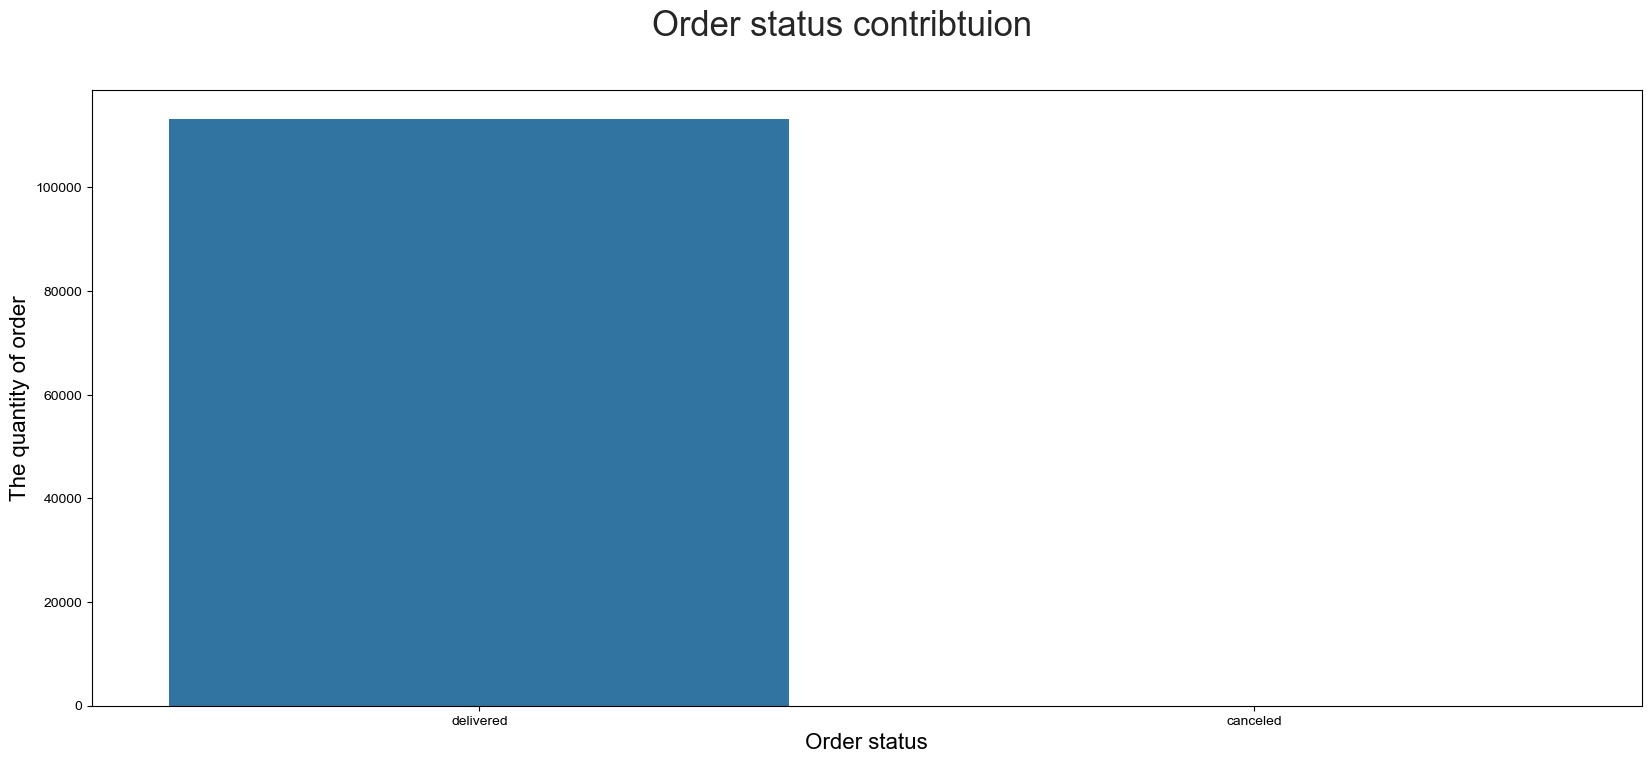

In [8]:
#Set the bar chart
fig = plt.figure(figsize = (20,8))
ax = plt.axes() 
sns.barplot(x = df_ecommerce.Order_status.value_counts().index, 
            y = df_ecommerce.Order_status.value_counts(), ax = ax)
sns.set(font_scale = 1)

#Set the label name
ax.set_xlabel('Order status', fontsize = 16)
ax.set_ylabel('The quantity of order', fontsize = 16)

#Set the Suptitle
fig.suptitle("Order status contribtuion", fontsize = 25)

plt.show()

In [9]:
#Filter bỏ những đơn hàng đã cancel
df_ecommerce = df_ecommerce[df_ecommerce['Order_status'] == 'delivered' ]

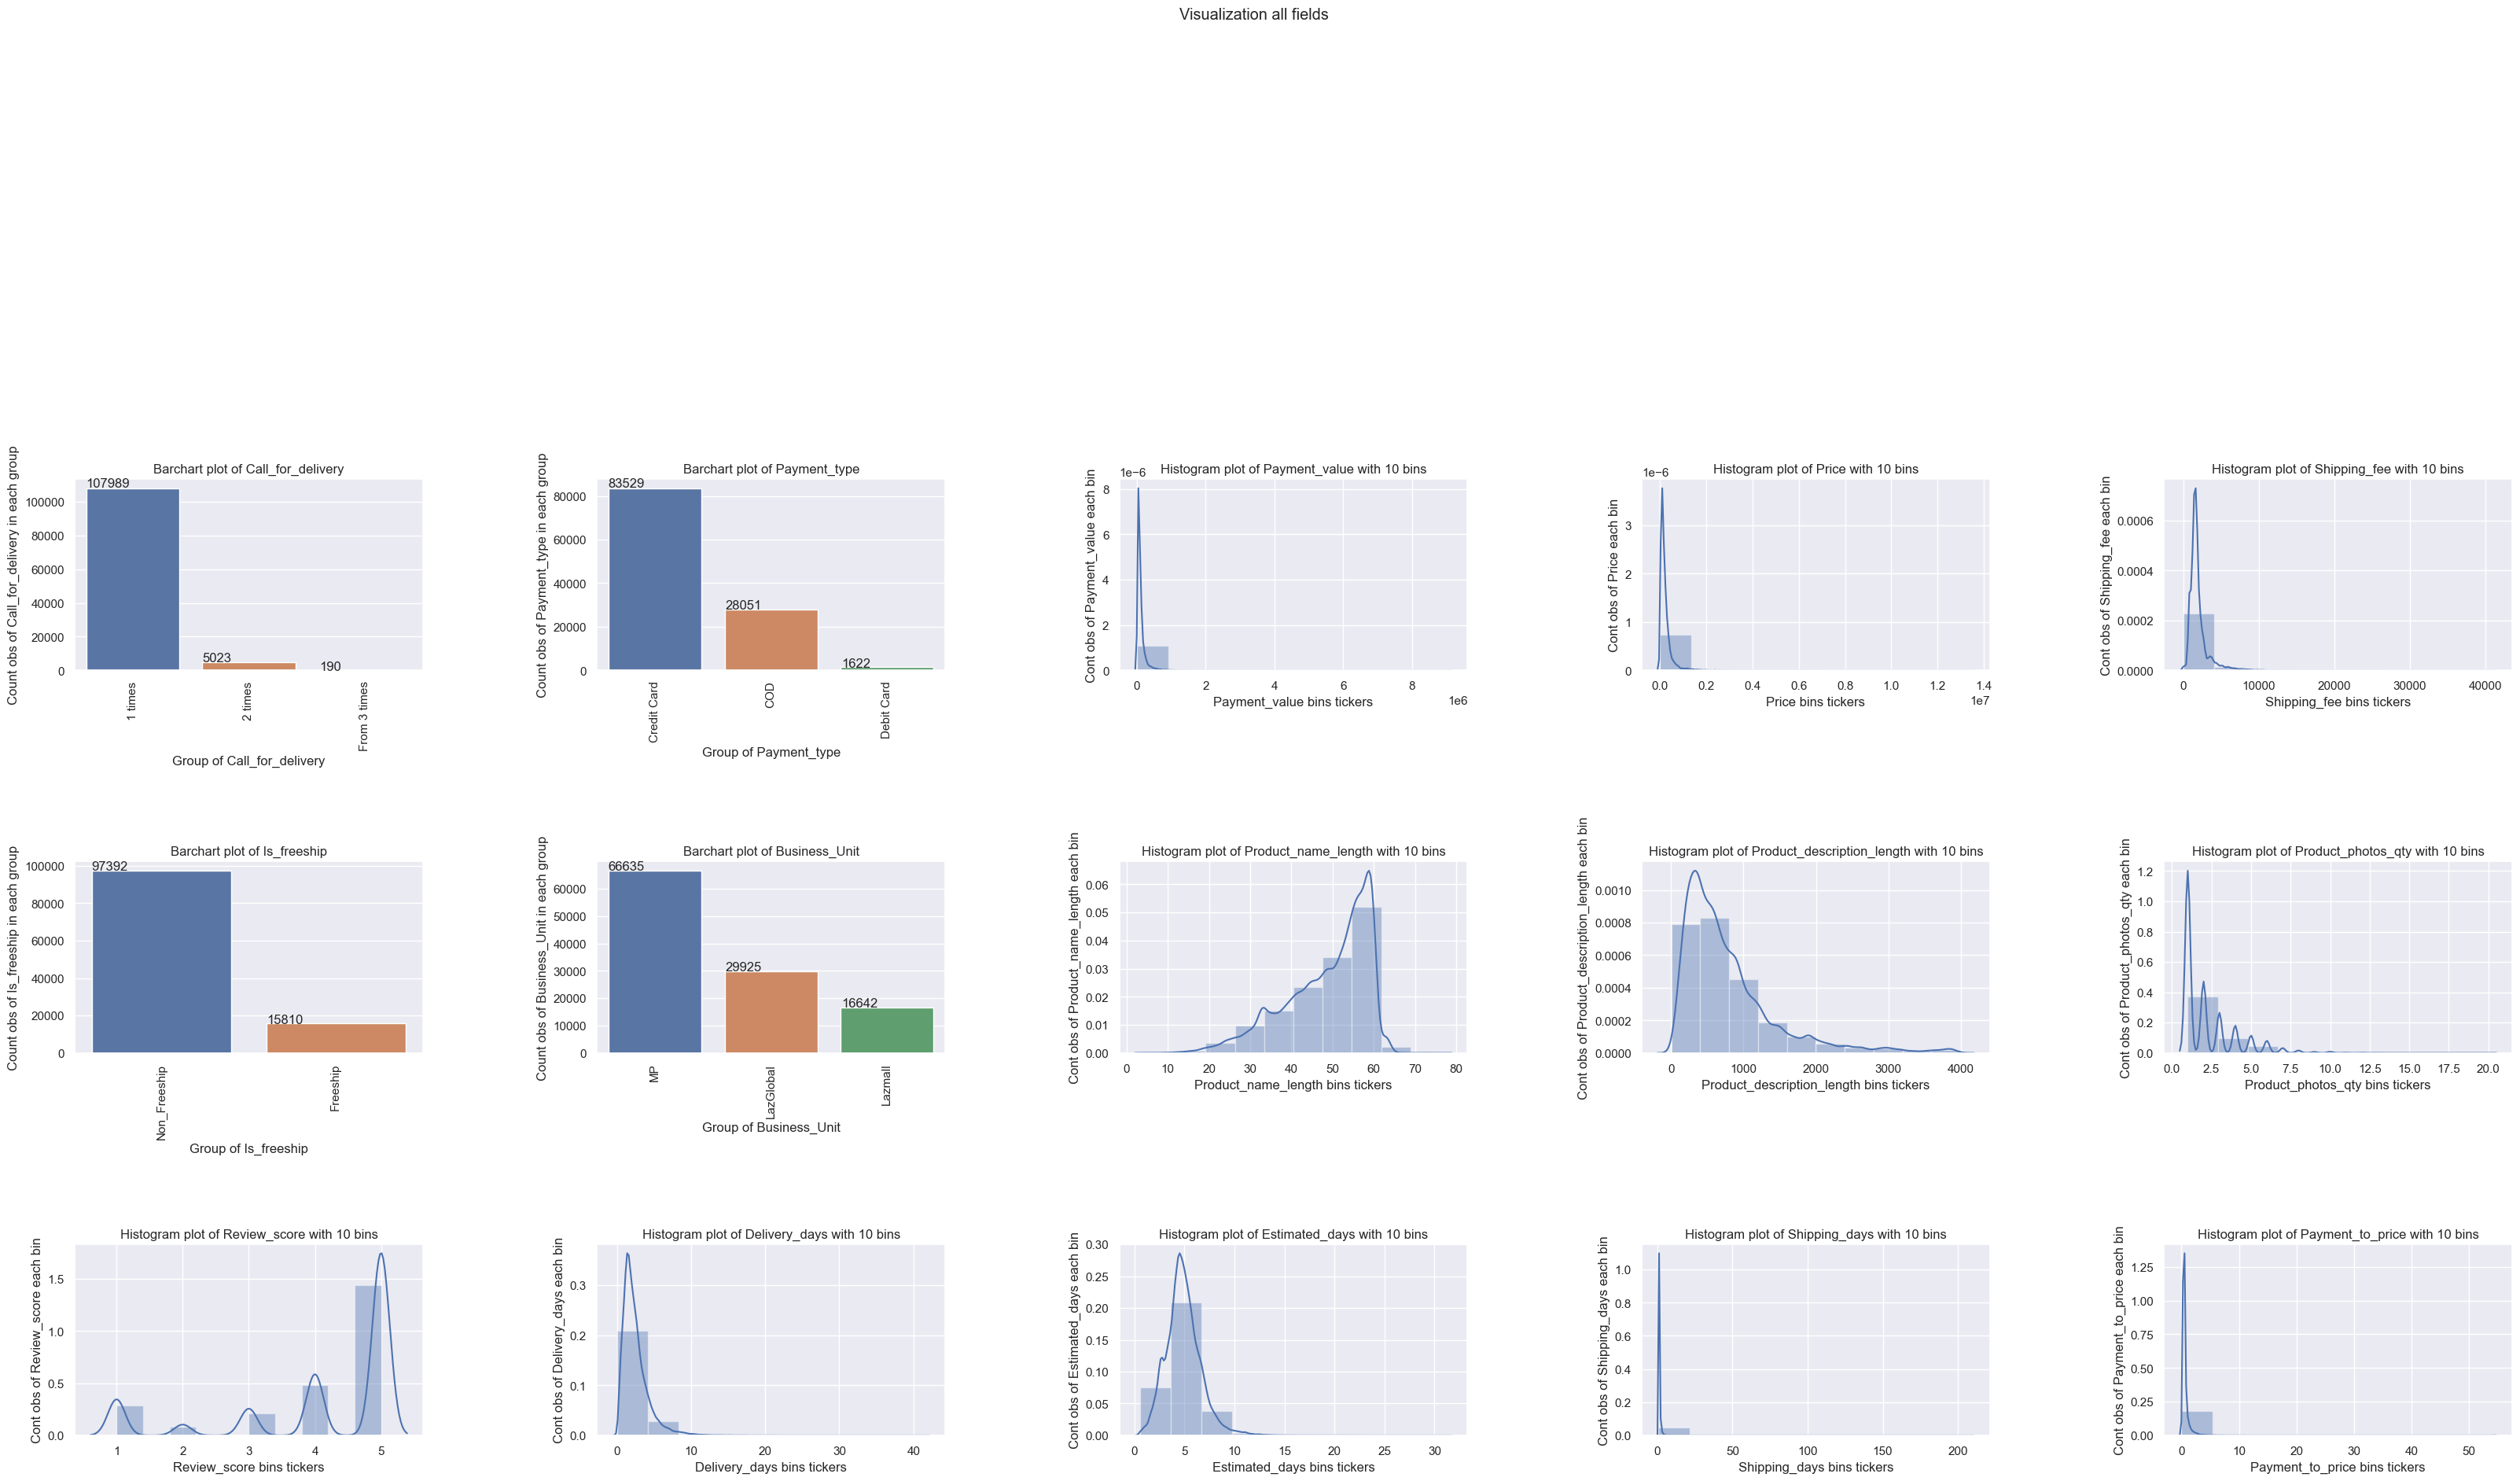

In [10]:
data = df_ecommerce.copy()
col = data.columns[5:]
# Create figure 
fig = plt.figure(figsize=(40, 60))
fig.subplots_adjust(hspace=1, wspace=0.5)
# Create loop for build up chart:
for i, (fieldname, dtype) in enumerate(zip(data[col].columns, data[col].dtypes.values)):
  if i <= 49:
    sub_chart = fig.add_subplot(10, 5, i+1)
    if dtype in ['float64', 'int64']:
      sub_chart = plot_hist_subplot(data[fieldname], colname=fieldname)
    else:
      sub_chart = plot_barchart_subplot(data[fieldname], colname=fieldname)
      
fig.suptitle('Visualization all fields')
plt.show()

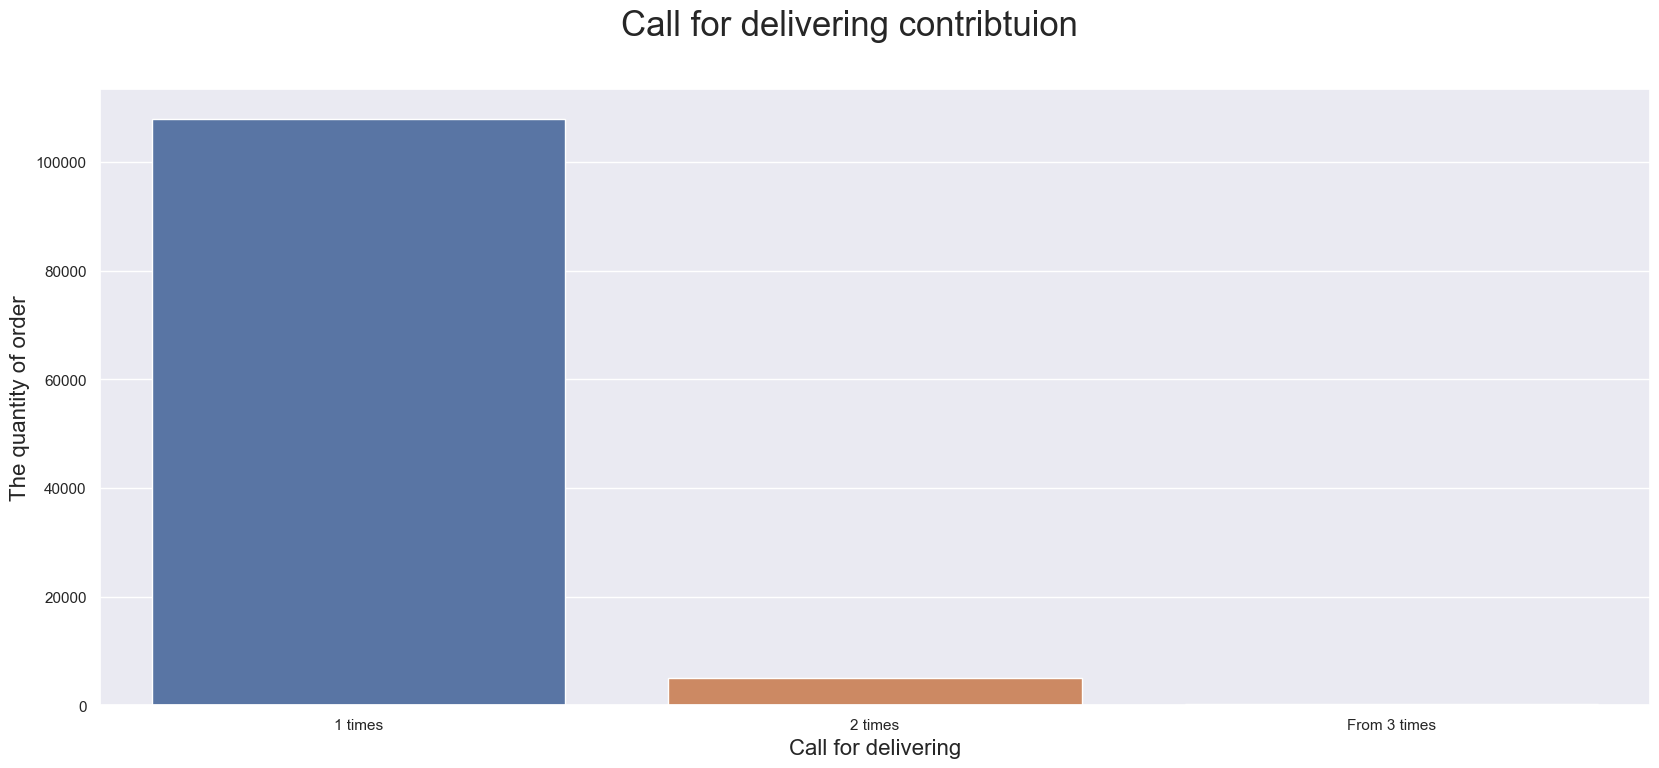

In [11]:
#Set the bar chart
fig = plt.figure(figsize = (20,8))
ax = plt.axes() 
sns.barplot(x = df_ecommerce.Call_for_delivery.value_counts().index, 
            y = df_ecommerce.Call_for_delivery.value_counts(), ax = ax)
sns.set(font_scale = 1)

#Set the label name
ax.set_xlabel('Call for delivering', fontsize = 16)
ax.set_ylabel('The quantity of order', fontsize = 16)

#Set the Suptitle
fig.suptitle("Call for delivering contribtuion", fontsize = 25)

plt.show()

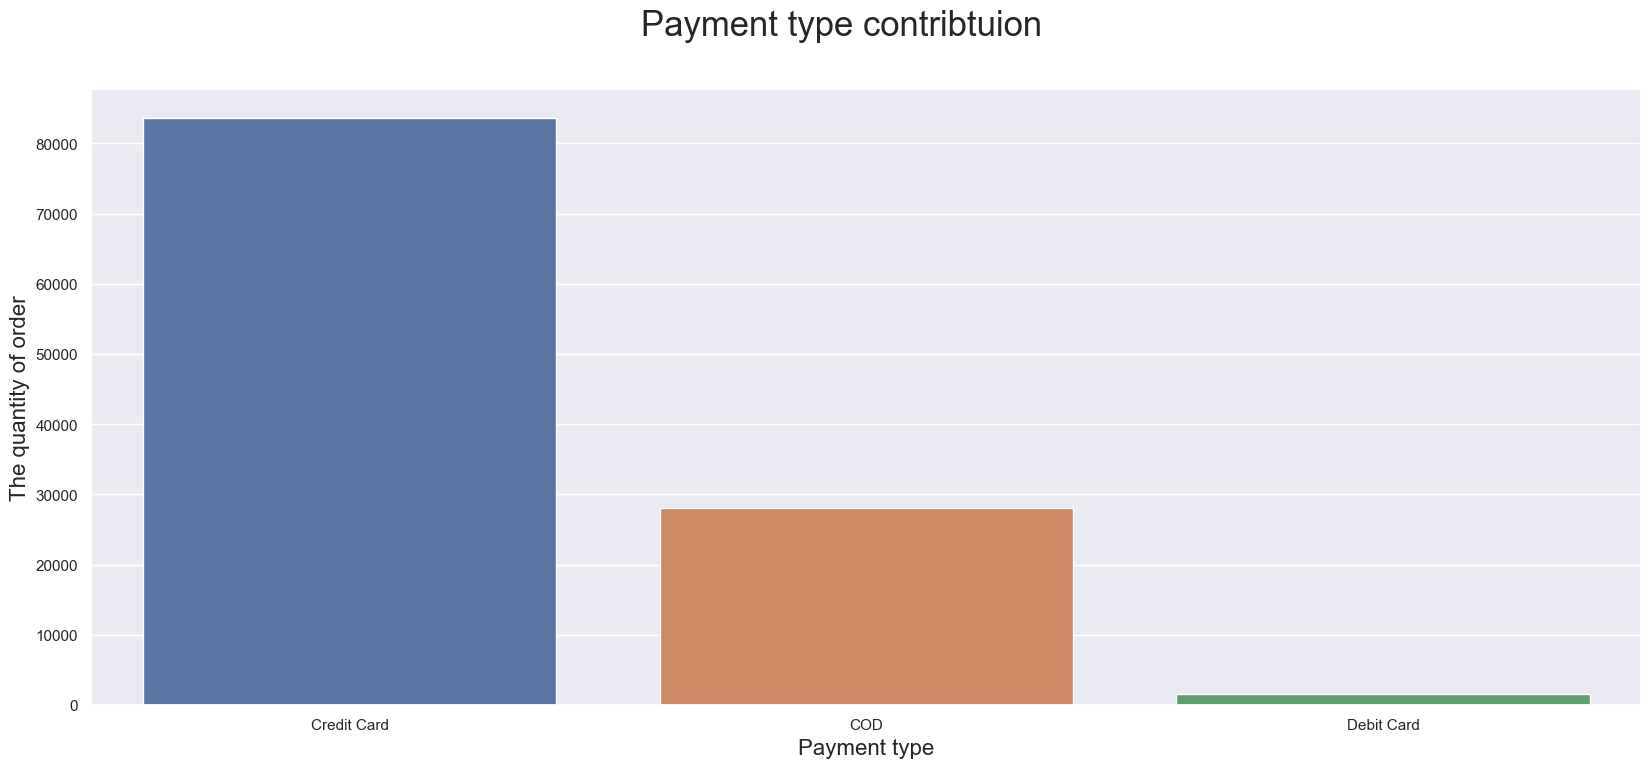

In [12]:
#Set the bar chart
fig = plt.figure(figsize = (20,8))
ax = plt.axes() 
sns.barplot(x = df_ecommerce.Payment_type.value_counts().index, 
            y = df_ecommerce.Payment_type.value_counts(), ax = ax)
sns.set(font_scale = 1)

#Set the label name
ax.set_xlabel('Payment type', fontsize = 16)
ax.set_ylabel('The quantity of order', fontsize = 16)

#Set the Suptitle
fig.suptitle("Payment type contribtuion", fontsize = 25)

plt.show()

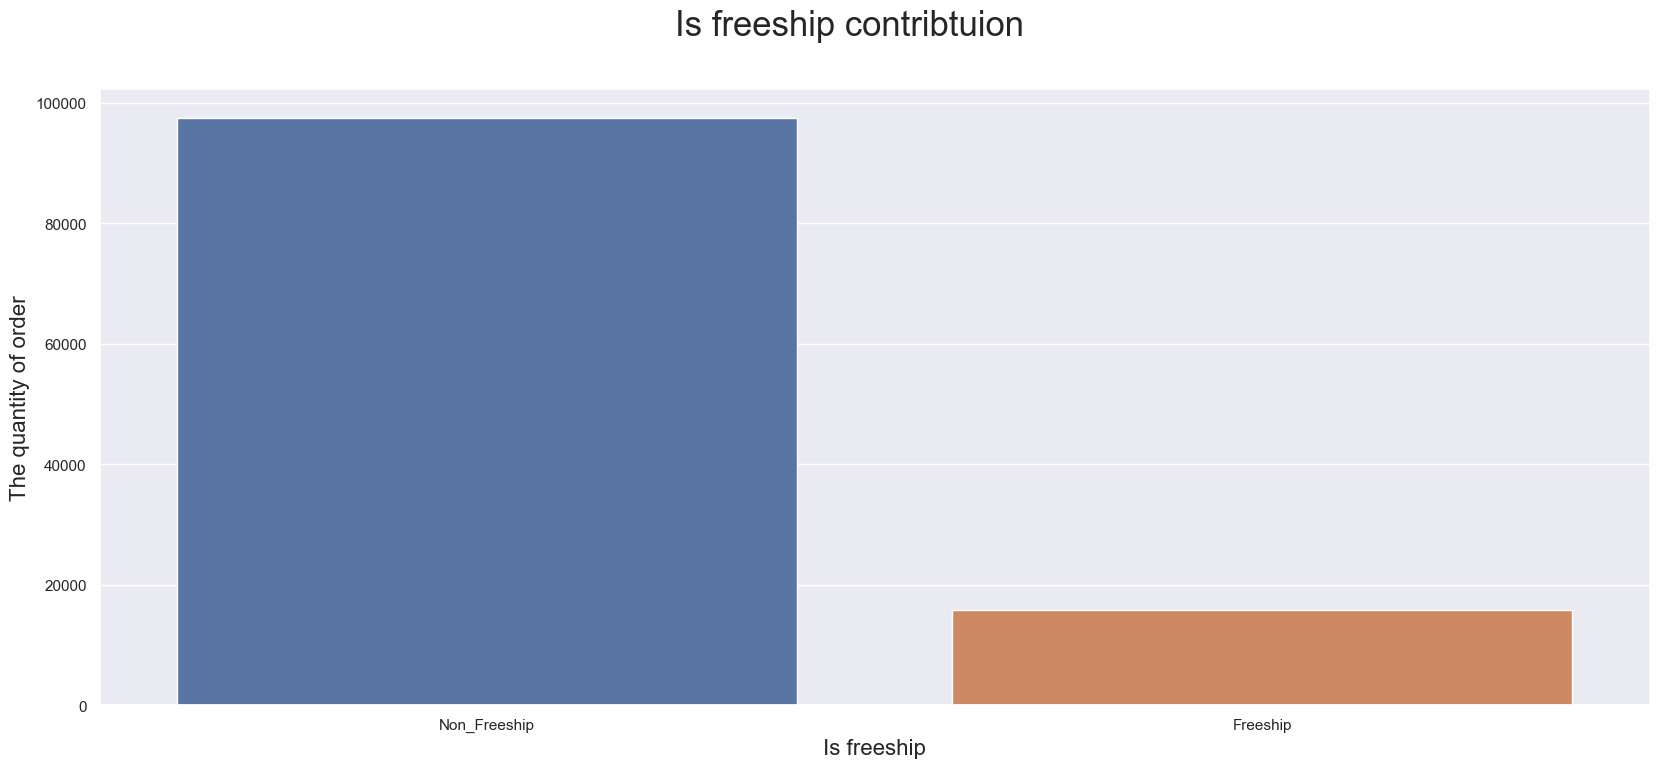

In [13]:
#Set the bar chart
fig = plt.figure(figsize = (20,8))
ax = plt.axes() 
sns.barplot(x = df_ecommerce.Is_freeship.value_counts().index, 
            y = df_ecommerce.Is_freeship.value_counts(), ax = ax)
sns.set(font_scale = 1)

#Set the label name
ax.set_xlabel('Is freeship', fontsize = 16)
ax.set_ylabel('The quantity of order', fontsize = 16)

#Set the Suptitle
fig.suptitle("Is freeship contribtuion", fontsize = 25)

plt.show()

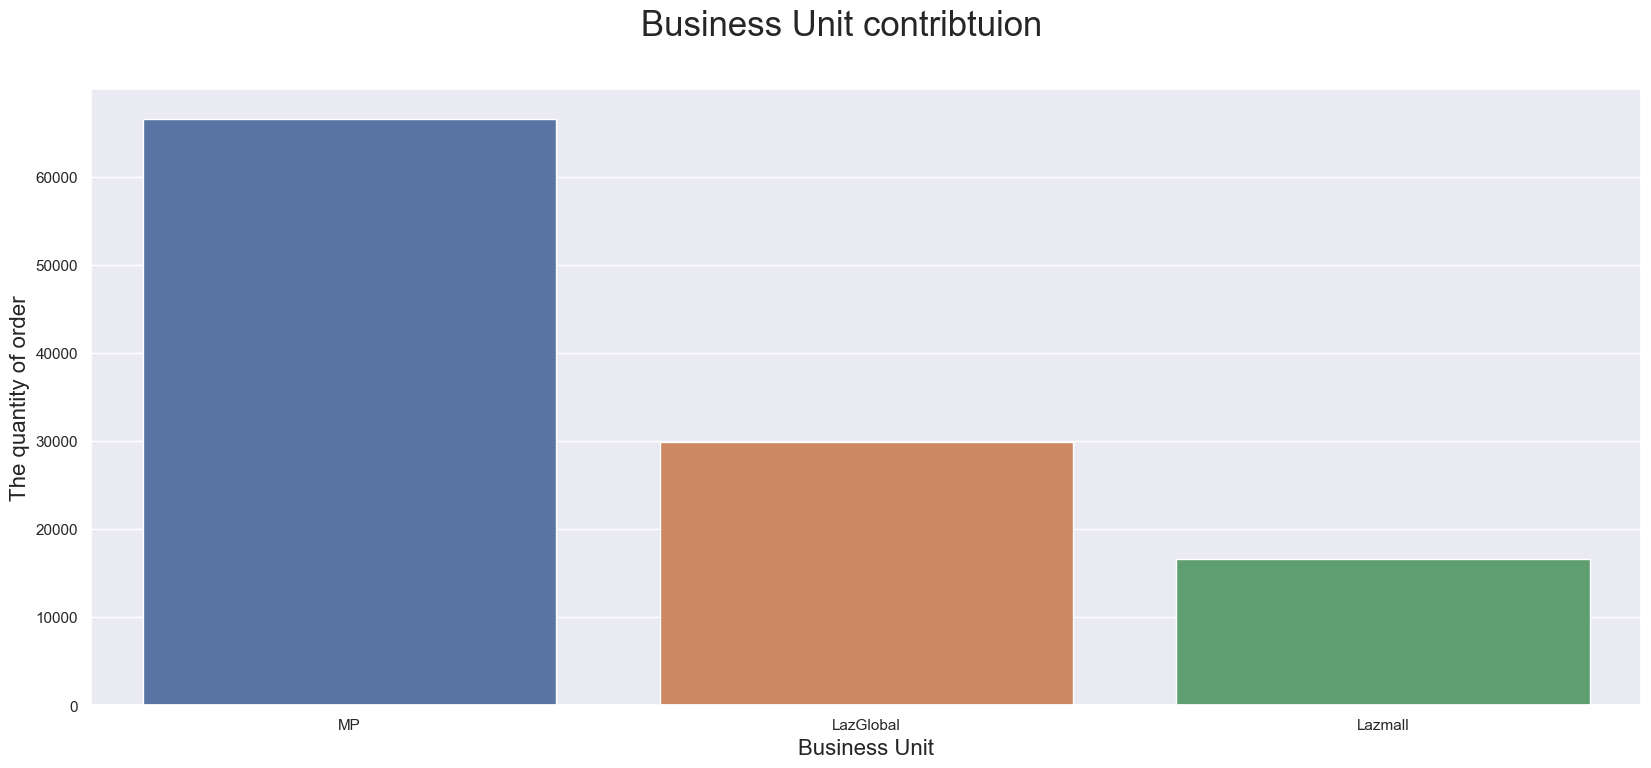

In [14]:
#Set the bar chart
fig = plt.figure(figsize = (20,8))
ax = plt.axes() 
sns.barplot(x = df_ecommerce.Business_Unit.value_counts().index, 
            y = df_ecommerce.Business_Unit.value_counts(), ax = ax)
sns.set(font_scale = 1)

#Set the label name
ax.set_xlabel('Business Unit', fontsize = 16)
ax.set_ylabel('The quantity of order', fontsize = 16)

#Set the Suptitle
fig.suptitle("Business Unit contribtuion", fontsize = 25)

plt.show()

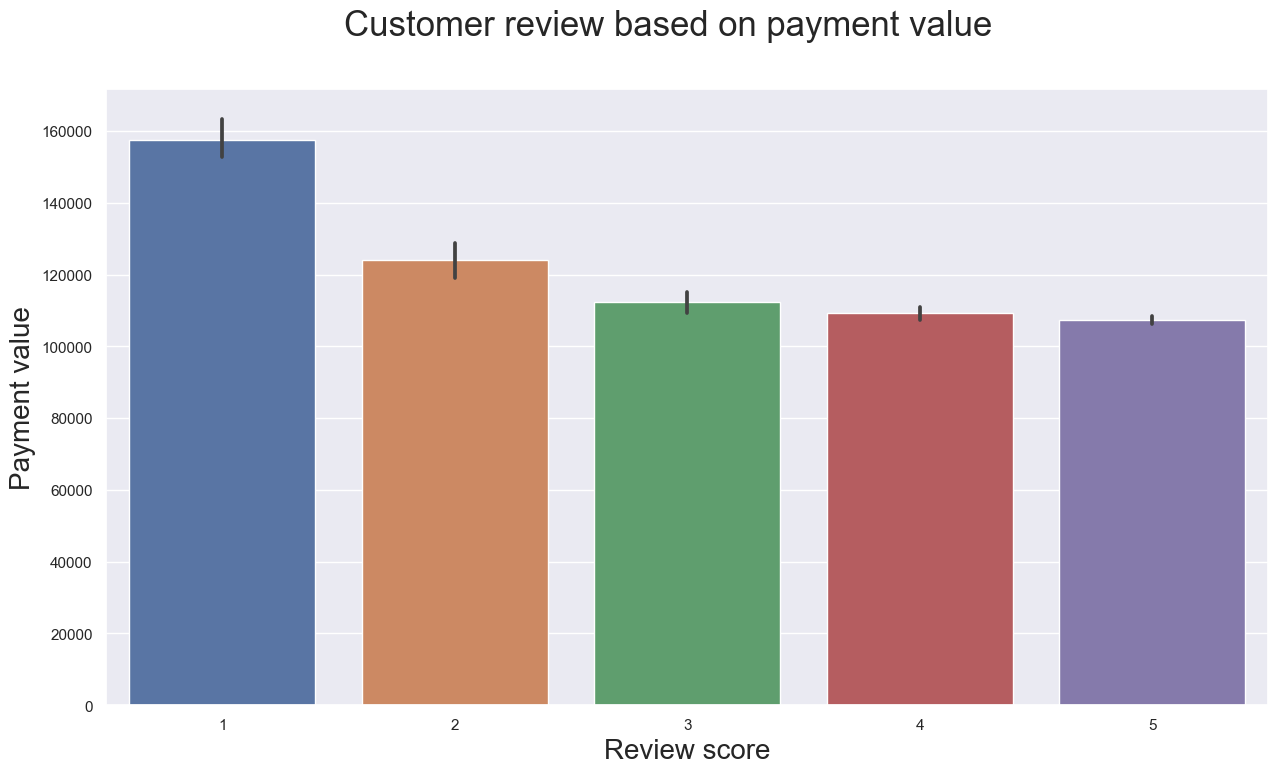

In [15]:
#Set the bar chart
fig = plt.figure(figsize = (15,8))
ax = plt.axes() 
sns.barplot(x = "Review_score", y = "Payment_value",
               data = df_ecommerce, 
               ax = ax)
sns.set(font_scale = 1.75)

#Set the label name
ax.set_xlabel('Review score', fontsize = 20)
ax.set_ylabel('Payment value', fontsize = 20)

#Set the Suptitle
fig.suptitle("Customer review based on payment value", fontsize = 25)

plt.show()

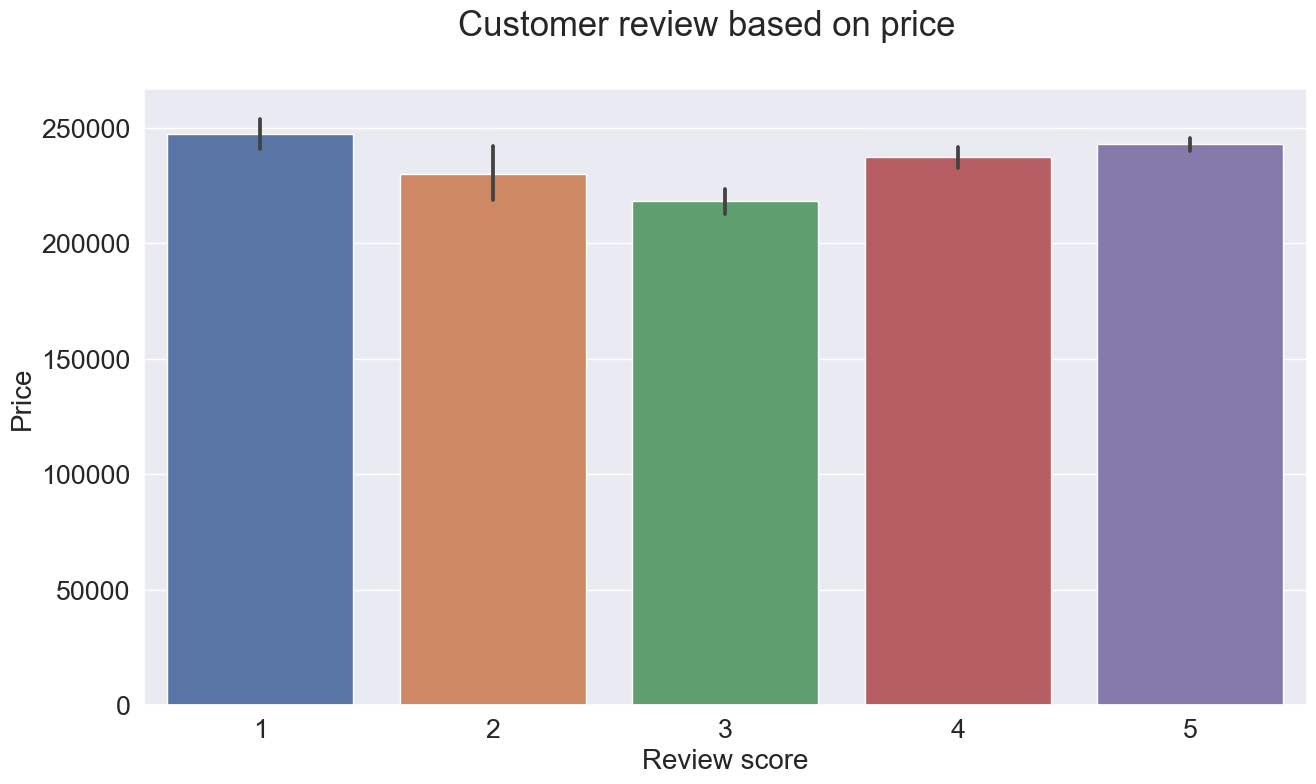

In [16]:
#Set the bar chart
fig = plt.figure(figsize = (15,8))
ax = plt.axes() 
sns.barplot(x = "Review_score", y = "Price",
               data = df_ecommerce, 
               ax = ax)
sns.set(font_scale = 1.75)

#Set the label name
ax.set_xlabel('Review score', fontsize = 20)
ax.set_ylabel('Price', fontsize = 20)

#Set the Suptitle
fig.suptitle("Customer review based on price", fontsize = 25)

plt.show()

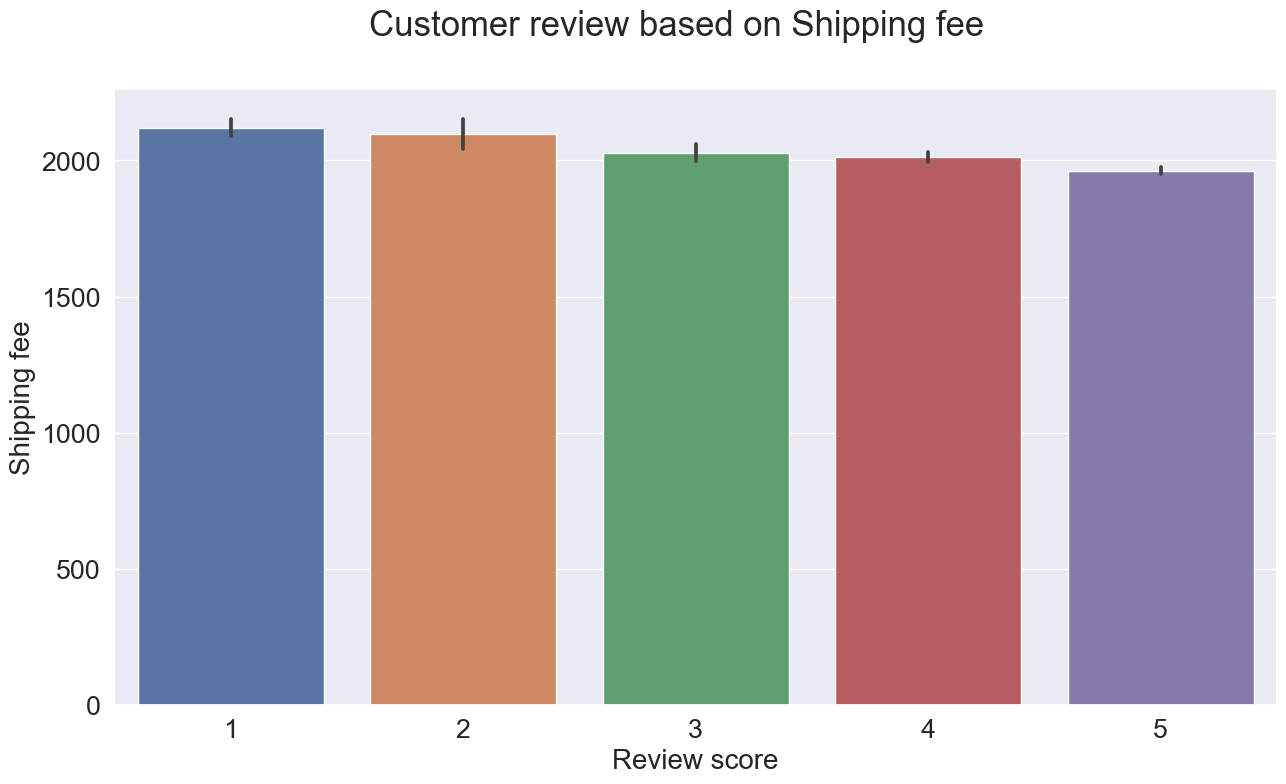

In [17]:
#Set the bar chart
fig = plt.figure(figsize = (15,8))
ax = plt.axes() 
sns.barplot(x = "Review_score", y = "Shipping_fee",
               data = df_ecommerce, 
               ax = ax)
sns.set(font_scale = 1.75)

#Set the label name
ax.set_xlabel('Review score', fontsize = 20)
ax.set_ylabel('Shipping fee', fontsize = 20)

#Set the Suptitle
fig.suptitle("Customer review based on Shipping fee", fontsize = 25)

plt.show()

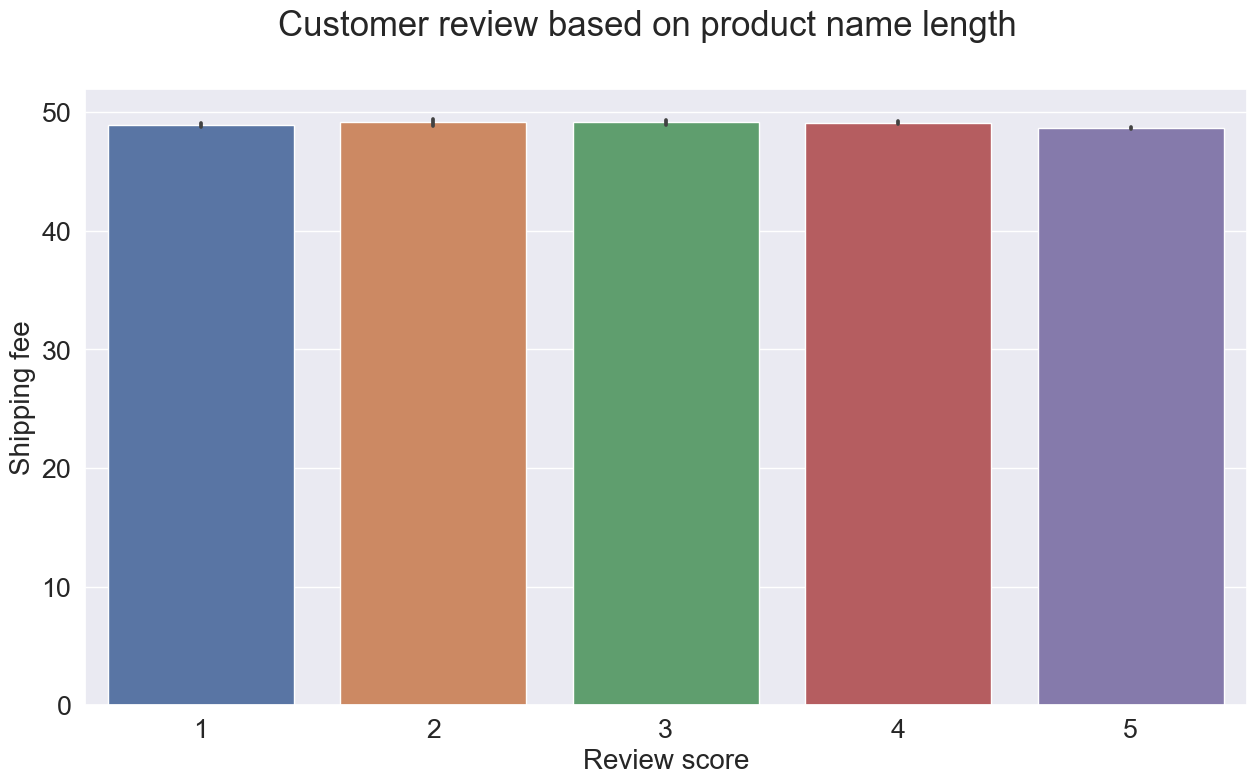

In [18]:
#Set the bar chart
fig = plt.figure(figsize = (15,8))
ax = plt.axes() 
sns.barplot(x = "Review_score", y = "Product_name_length",
               data = df_ecommerce, 
               ax = ax)
sns.set(font_scale = 1.75)

#Set the label name
ax.set_xlabel('Review score', fontsize = 20)
ax.set_ylabel('Shipping fee', fontsize = 20)

#Set the Suptitle
fig.suptitle("Customer review based on product name length", fontsize = 25)

plt.show()

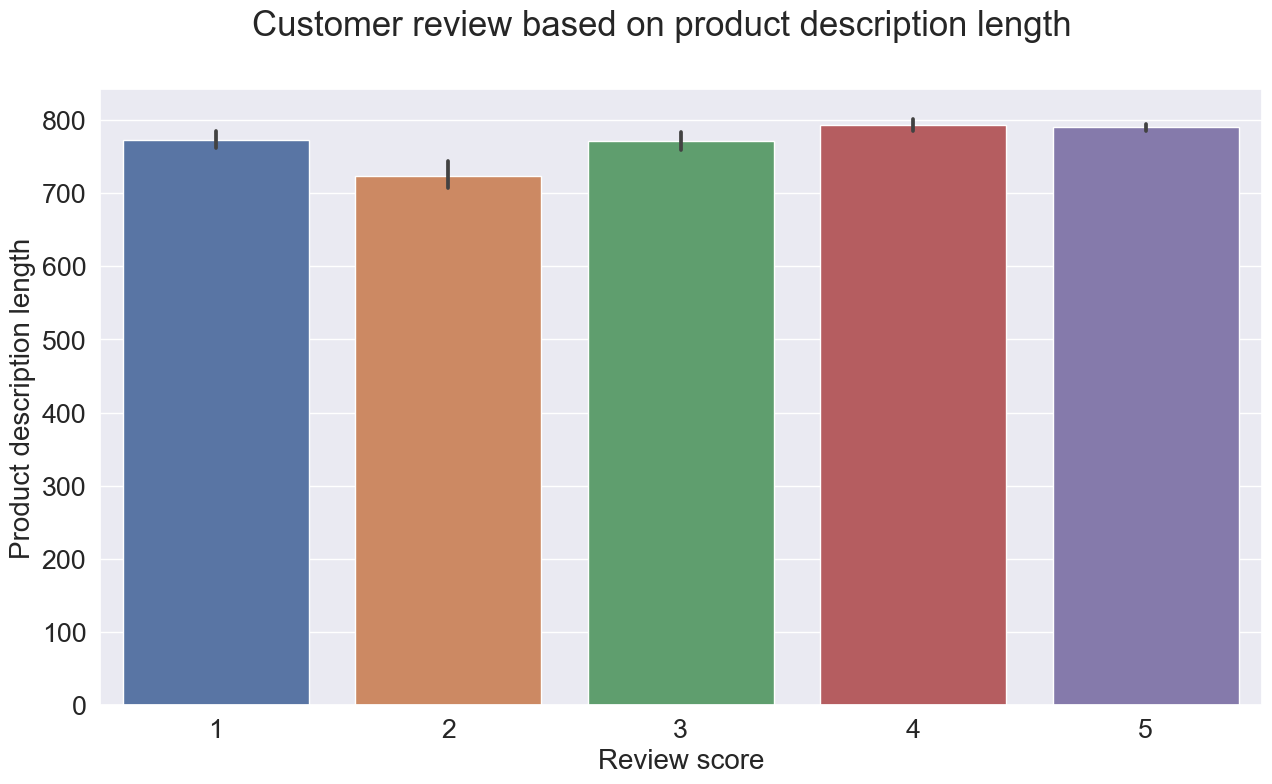

In [19]:
#Set the bar chart
fig = plt.figure(figsize = (15,8))
ax = plt.axes() 
sns.barplot(x = "Review_score", y = "Product_description_length",
               data = df_ecommerce, 
               ax = ax)
sns.set(font_scale = 1.75)

#Set the label name
ax.set_xlabel('Review score', fontsize = 20)
ax.set_ylabel('Product description length', fontsize = 20)

#Set the Suptitle
fig.suptitle("Customer review based on product description length", fontsize = 25)

plt.show()

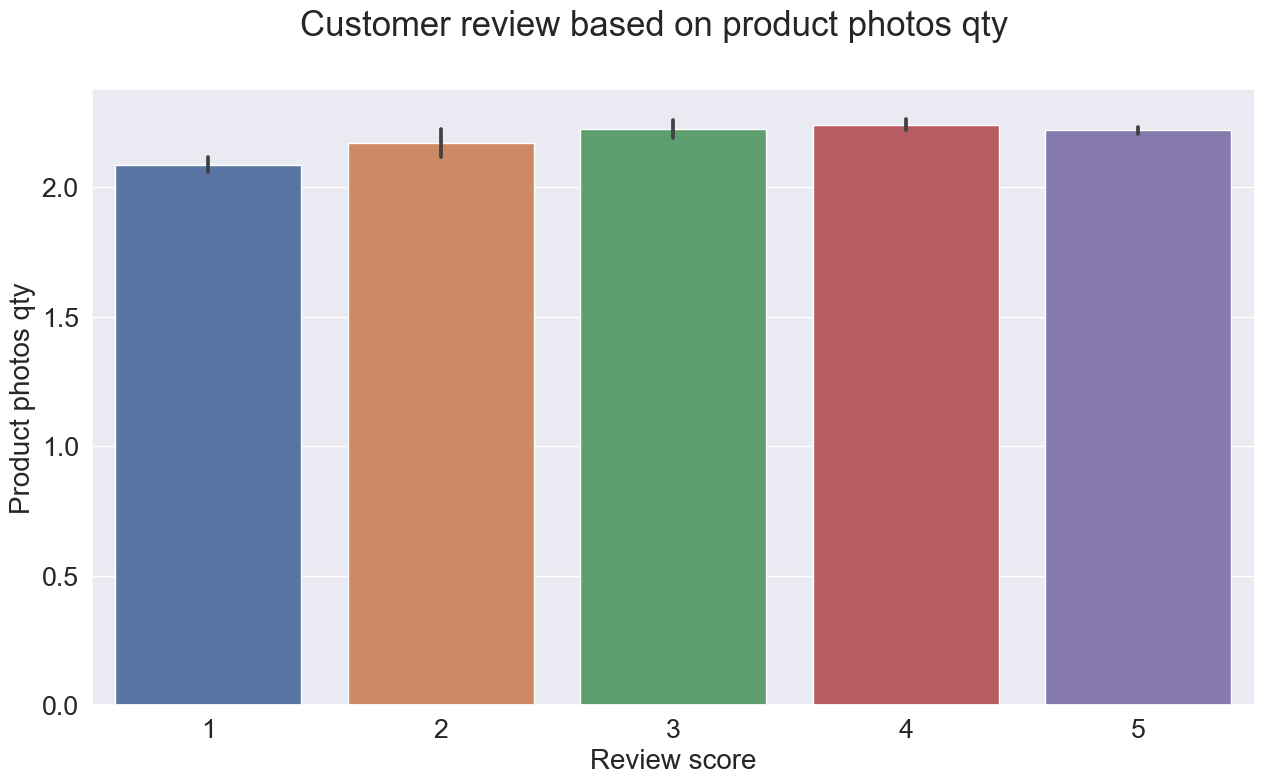

In [20]:
#Set the bar chart
fig = plt.figure(figsize = (15,8))
ax = plt.axes() 
sns.barplot(x = "Review_score", y = "Product_photos_qty",
               data = df_ecommerce, 
               ax = ax)
sns.set(font_scale = 1.75)

#Set the label name
ax.set_xlabel('Review score', fontsize = 20)
ax.set_ylabel('Product photos qty', fontsize = 20)

#Set the Suptitle
fig.suptitle("Customer review based on product photos qty", fontsize = 25)

plt.show()

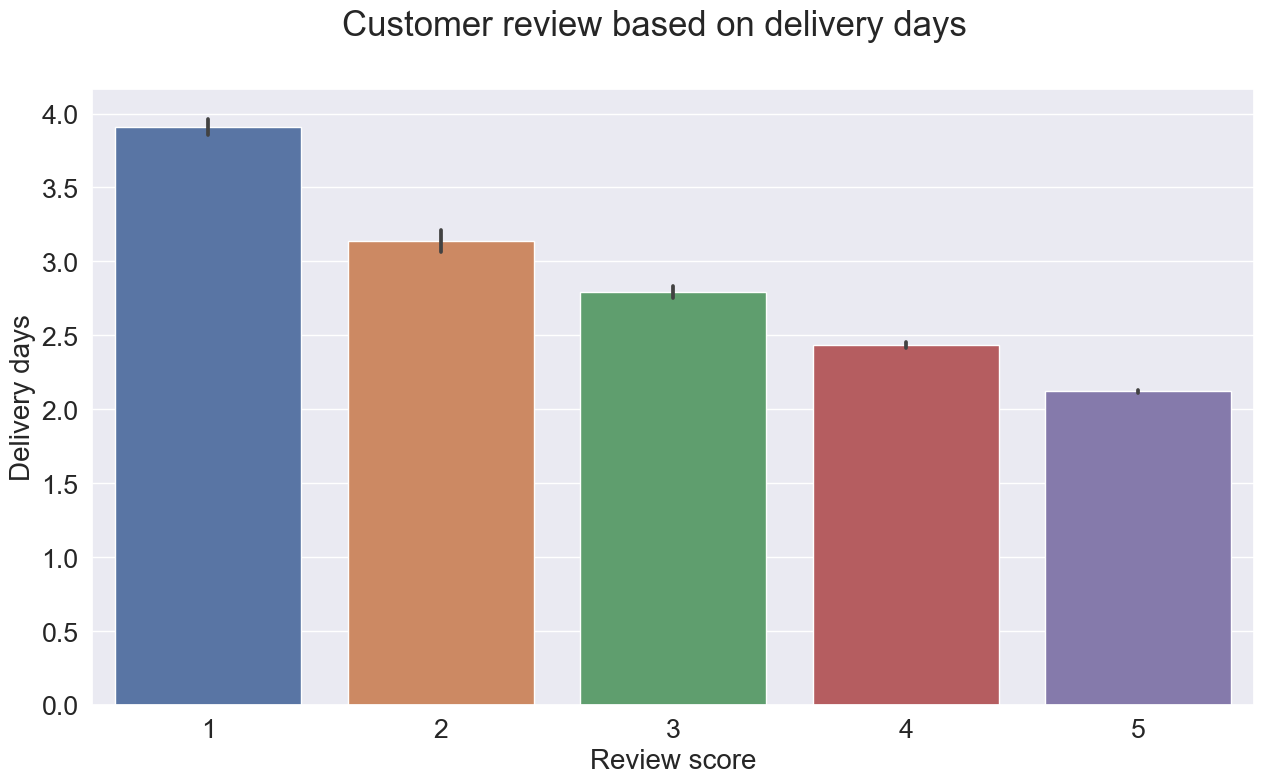

In [21]:
#Set the bar chart
fig = plt.figure(figsize = (15,8))
ax = plt.axes() 
sns.barplot(x = "Review_score", y = "Delivery_days",
               data = df_ecommerce, 
               ax = ax)
sns.set(font_scale = 1.75)

#Set the label name
ax.set_xlabel('Review score', fontsize = 20)
ax.set_ylabel('Delivery days', fontsize = 20)

#Set the Suptitle
fig.suptitle("Customer review based on delivery days", fontsize = 25)

plt.show()

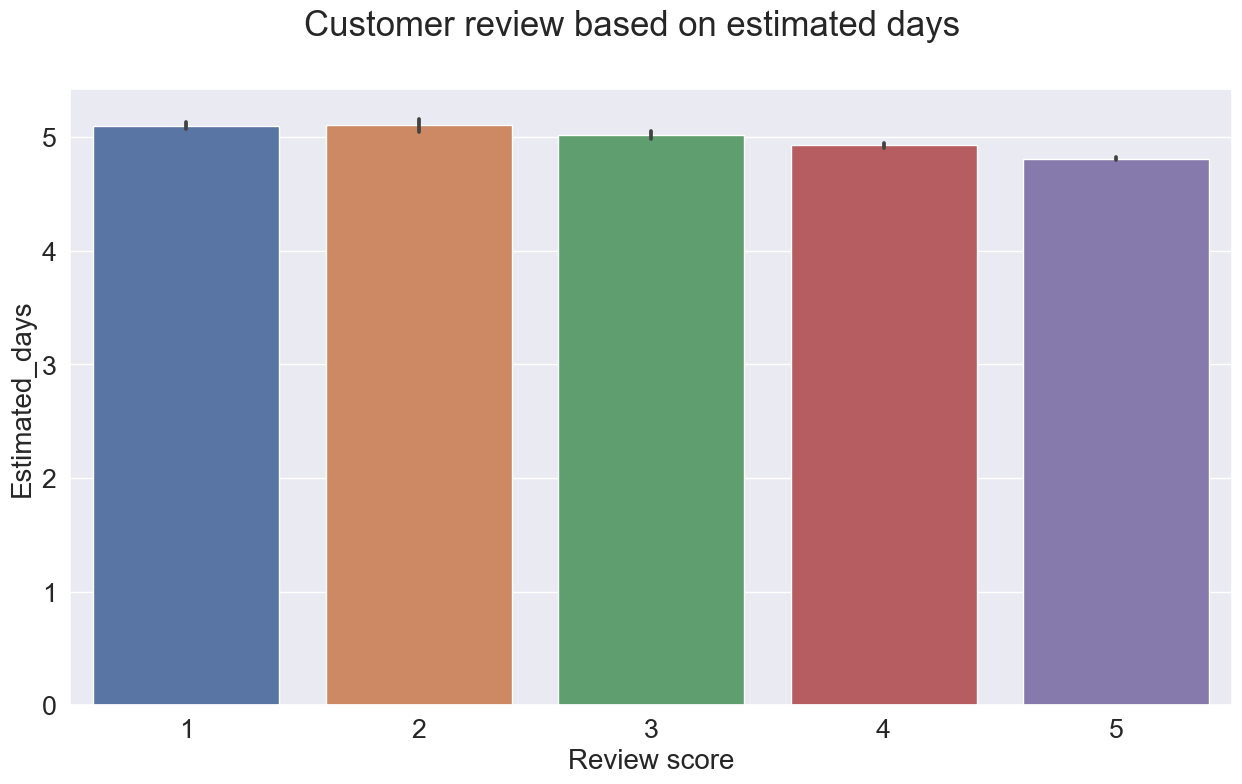

In [22]:
#Set the bar chart
fig = plt.figure(figsize = (15,8))
ax = plt.axes() 
sns.barplot(x = "Review_score", y = "Estimated_days",
               data = df_ecommerce, 
               ax = ax)
sns.set(font_scale = 1.75)

#Set the label name
ax.set_xlabel('Review score', fontsize = 20)
ax.set_ylabel('Estimated_days', fontsize = 20)

#Set the Suptitle
fig.suptitle("Customer review based on estimated days", fontsize = 25)

plt.show()

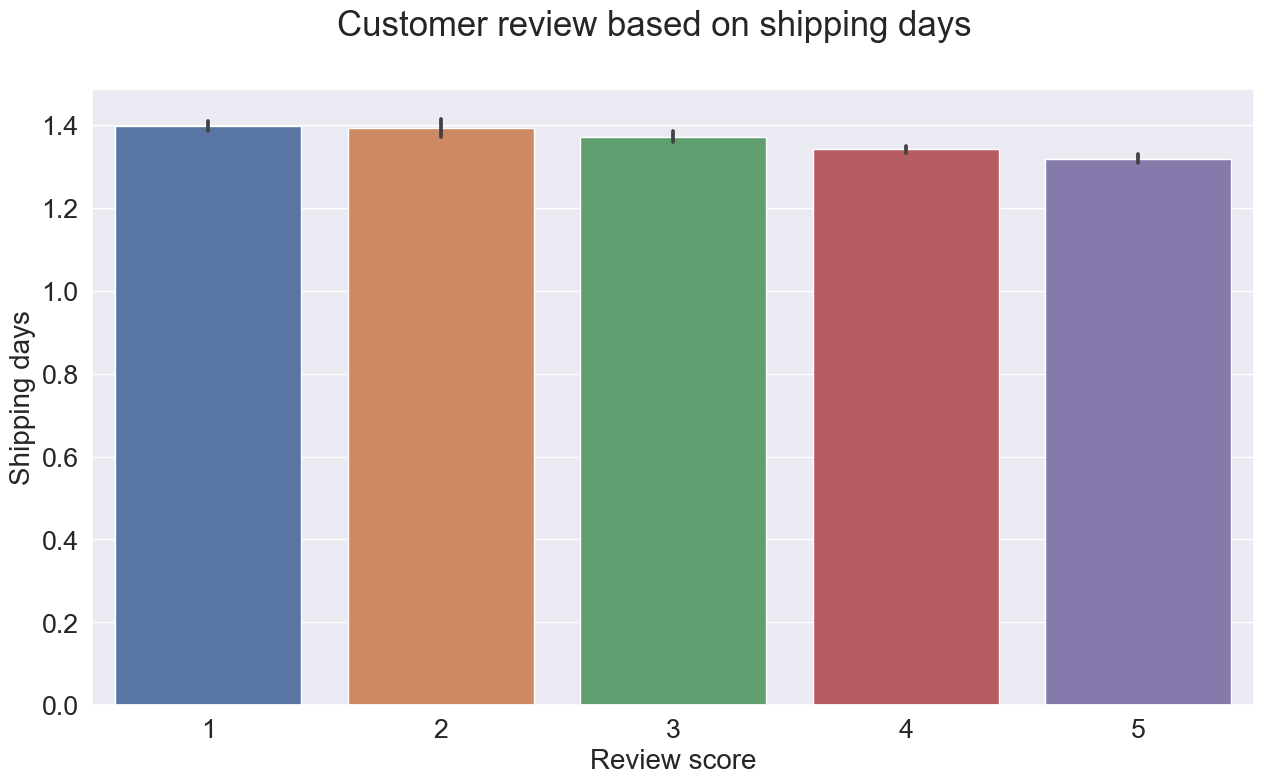

In [23]:
#Set the bar chart
fig = plt.figure(figsize = (15,8))
ax = plt.axes() 
sns.barplot(x = "Review_score", y = "Shipping_days",
               data = df_ecommerce, 
               ax = ax)
sns.set(font_scale = 1.75)

#Set the label name
ax.set_xlabel('Review score', fontsize = 20)
ax.set_ylabel('Shipping days', fontsize = 20)

#Set the Suptitle
fig.suptitle("Customer review based on shipping days", fontsize = 25)

plt.show()

In [24]:
#Creating new column of arrival time
df_ecommerce['Arrival_time'] = (df_ecommerce['Estimated_days'] - df_ecommerce['Delivery_days'])

#Creating new feature based on the arrival time of each order
delivery_arrival = []
d_arrival = df_ecommerce.Arrival_time.values.tolist()

for i in d_arrival:
  if i <= 0:
    delivery_arrival.append('Late')
  else:
    delivery_arrival.append('On time')

df_ecommerce['Delivery_arrival'] = delivery_arrival

In [25]:
#Creating new feature based on the review score of each order of good and bad review
df_ecommerce.loc[df_ecommerce['Review_score'] < 3 ,'Score'] = 0
df_ecommerce.loc[df_ecommerce['Review_score'] > 3,'Score'] = 1

#Removing review with value of 3 because it is a neutral review
df_ecommerce.drop(df_ecommerce[df_ecommerce['Review_score'] == 3].index,inplace=True)
df_ecommerce.drop('Review_score',axis=1,inplace=True)
print(df_ecommerce.shape)

(103669, 22)


In [26]:
#So sánh correlation giữa các biến 
df_ecommerce.select_dtypes('float64','int64').corr().sort_values('Score').style.format(precision=1).background_gradient(axis=None,subset = ['Payment_value','Price','Shipping_fee','Delivery_days','Estimated_days','Shipping_days','Payment_to_price','Arrival_time']).background_gradient(axis=None,subset = ['Score'],cmap = 'BuGn')

,Payment_value,Price,Shipping_fee,Delivery_days,Estimated_days,Shipping_days,Payment_to_price,Arrival_time,Score
Delivery_days,0.1,0.1,0.2,1.0,0.4,0.1,-0.0,-0.6,-0.3
Payment_to_price,0.1,-0.1,-0.0,-0.0,0.0,0.0,1.0,0.0,-0.1
Payment_value,1.0,0.7,0.4,0.1,0.1,0.0,0.1,0.0,-0.1
Estimated_days,0.1,0.1,0.3,0.4,1.0,0.3,0.0,0.5,-0.1
Shipping_fee,0.4,0.4,1.0,0.2,0.3,0.1,-0.0,0.0,-0.0
Shipping_days,0.0,0.0,0.1,0.1,0.3,1.0,0.0,0.1,-0.0
Price,0.7,1.0,0.4,0.1,0.1,0.0,-0.1,0.0,-0.0
Arrival_time,0.0,0.0,0.0,-0.6,0.5,0.1,0.0,1.0,0.2
Score,-0.1,-0.0,-0.0,-0.3,-0.1,-0.0,-0.1,0.2,1.0


In [27]:
# Tính hệ số Information value để chọn ra biến tốt 
data = df_ecommerce.copy()
col = data.columns[5:20]
iv_table = {}
bin_transform = {}
woe_transform = {}
for i, (fieldname, dtype) in enumerate(zip(data[col].columns, data[col].dtypes.values)):
    if dtype in ['float64', 'int64']:
        x = data[fieldname].values
        y = data['Score']
        optb = OptimalBinning(name=fieldname, dtype="numerical", solver="cp")
        optb.fit(x, y)
        binning_table = optb.binning_table
        iv = binning_table.build()
        
        iv_table[fieldname] = iv.loc['Totals',['Count','Event rate','IV']]
        bin_transform[fieldname] = optb.transform(x, metric="bins")
        woe_transform[fieldname] = optb.transform(x, metric="woe")
    if dtype in ['object']:
        x = data[fieldname].values
        y = data['Score'].values
        optb = OptimalBinning(name=fieldname, dtype="categorical", solver="mip",
                      cat_cutoff=0.1)
        optb.fit(x,y)
        iv = optb.binning_table.build()
        iv_table[fieldname] = iv.loc['Totals',['Count','Event rate','IV']]
        bin_transform[fieldname] = optb.transform(x, metric="bins")
        woe_transform[fieldname] = optb.transform(x, metric="woe")

In [28]:
iv_result = pd.DataFrame(iv_table).transpose().sort_values('IV',ascending=False)
iv_result.style.background_gradient(axis=None,subset = ['IV'])

,Count,Event rate,IV
Arrival_time,103669,0.838901,0.786859
Delivery_days,103669,0.838901,0.605117
Payment_to_price,103669,0.838901,0.233669
Payment_value,103669,0.838901,0.077769
Estimated_days,103669,0.838901,0.031645
Business_Unit,103669,0.838901,0.027863
Shipping_days,103669,0.838901,0.020926
Shipping_fee,103669,0.838901,0.015150
Product_description_length,103669,0.838901,0.008681
Product_photos_qty,103669,0.838901,0.007874


# Feature Engineering

In [29]:
#Label and one hot encoding process
#Handling column with 2 distinct value
df_ecommerce['Order_status'] = df_ecommerce['Order_status'].replace(['canceled','delivered'],[0,1])
df_ecommerce['Delivery_arrival'] = df_ecommerce['Delivery_arrival'].replace(['Late','On time'],[0,1])

#Handling column with more than 2 distinct value
one_hot_payment_type = pd.get_dummies(df_ecommerce['Payment_type'])
df_ecommerce = df_ecommerce.join(one_hot_payment_type)
one_hot_call_delivery = pd.get_dummies(df_ecommerce['Call_for_delivery'])
df_ecommerce = df_ecommerce.join(one_hot_call_delivery)
one_hot_bu = pd.get_dummies(df_ecommerce['Business_Unit'])
df_ecommerce = df_ecommerce.join(one_hot_bu)
one_hot_fs = pd.get_dummies(df_ecommerce['Is_freeship'])
df_ecommerce = df_ecommerce.join(one_hot_fs)

In [30]:
# df_ecommerce.drop(columns = ['Payment_type','Call_for_delivery','Business_Unit','Is_freeship'],inplace = True)

In [31]:
df_ecommerce.drop(columns = ['Order_date','Delivered_date','Promised_delivery_date','Seller_transfer_date','Arrival_time'],inplace = True)

In [32]:
# df_ecommerce['Delivery_days'] = df_ecommerce['Delivery_days'].apply(lambda x:x/10)
# df_ecommerce['Estimated_days'] = df_ecommerce['Estimated_days'].apply(lambda x:x/10)
# df_ecommerce['Shipping_days'] = df_ecommerce['Shipping_days'].apply(lambda x:x/10)

In [33]:
#Droping any unimportant column for predicting process
#df_ecommerce.drop(['payment_type','product_category'],axis=1,inplace=True)

df_ecommerce.head()

,Order_status,Call_for_delivery,Payment_type,Payment_value,Price,Shipping_fee,Is_freeship,Business_Unit,Product_name_length,Product_description_length,...,Credit Card,Debit Card,1 times,2 times,From 3 times,LazGlobal,Lazmall,MP,Freeship,Non_Freeship
0,1,1 times,Credit Card,12080.000000,59980.0,872.0,Freeship,MP,40,268,...,True,False,True,False,False,False,False,True,True,False
1,1,2 times,COD,1333.333333,59980.0,872.0,Freeship,MP,40,268,...,False,False,False,True,False,False,False,True,True,False
2,1,2 times,COD,12393.333333,59980.0,872.0,Freeship,MP,40,268,...,False,False,False,True,False,False,False,True,True,False
3,1,1 times,COD,94306.666667,237400.0,2276.0,Non_Freeship,Lazmall,29,178,...,False,False,True,False,False,False,True,False,False,True
4,1,2 times,Credit Card,119413.333333,319800.0,1922.0,Non_Freeship,MP,46,232,...,True,False,False,True,False,False,False,True,False,True


In [34]:
df_ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103669 entries, 0 to 113208
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Order_status                103669 non-null  int64  
 1   Call_for_delivery           103669 non-null  object 
 2   Payment_type                103669 non-null  object 
 3   Payment_value               103669 non-null  float64
 4   Price                       103669 non-null  float64
 5   Shipping_fee                103669 non-null  float64
 6   Is_freeship                 103669 non-null  object 
 7   Business_Unit               103669 non-null  object 
 8   Product_name_length         103669 non-null  int64  
 9   Product_description_length  103669 non-null  int64  
 10  Product_photos_qty          103669 non-null  int64  
 11  Delivery_days               103669 non-null  float64
 12  Estimated_days              103669 non-null  float64
 13  Shipping_days      

# Split the data into Training & Testing

In [35]:
# Split the data
X = df_ecommerce[['Delivery_arrival','Delivery_days','Payment_to_price']].to_numpy()
y = df_ecommerce[['Score']].to_numpy()
y = y.reshape(len(y),) # sklearn's shape requirement

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [36]:
df_ecommerce['Score']

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
113204    1.0
113205    1.0
113206    0.0
113207    0.0
113208    1.0
Name: Score, Length: 103669, dtype: float64

# Decision Tree Classifier

In [37]:
#Define Decision tree classifier model
dt_clf = DecisionTreeClassifier(random_state=42)

In [38]:
%%time
#Hyperparameter tuning
param = {'max_depth':  [1,2,3], 'min_samples_split': [100, 200, 300, 400,700,1000]}

#Grid search CV
dt_clf_gridcv = GridSearchCV(dt_clf,param,cv=3,refit=True,return_train_score=True,scoring='accuracy')
dt_clf_gridcv.fit(X_train,y_train)

CPU times: total: 2.39 s
Wall time: 2.39 s


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3],
                         'min_samples_split': [100, 200, 300, 400, 700, 1000]},
             return_train_score=True, scoring='accuracy')

In [39]:
#Results of GridSearchCV
cv_result = pd.DataFrame(dt_clf_gridcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
8,"{'max_depth': 2, 'min_samples_split': 300}",0.861783,1
15,"{'max_depth': 3, 'min_samples_split': 400}",0.861783,1
14,"{'max_depth': 3, 'min_samples_split': 300}",0.861783,1
13,"{'max_depth': 3, 'min_samples_split': 200}",0.861783,1
12,"{'max_depth': 3, 'min_samples_split': 100}",0.861783,1
11,"{'max_depth': 2, 'min_samples_split': 1000}",0.861783,1
10,"{'max_depth': 2, 'min_samples_split': 700}",0.861783,1
9,"{'max_depth': 2, 'min_samples_split': 400}",0.861783,1
17,"{'max_depth': 3, 'min_samples_split': 1000}",0.861783,1
7,"{'max_depth': 2, 'min_samples_split': 200}",0.861783,1


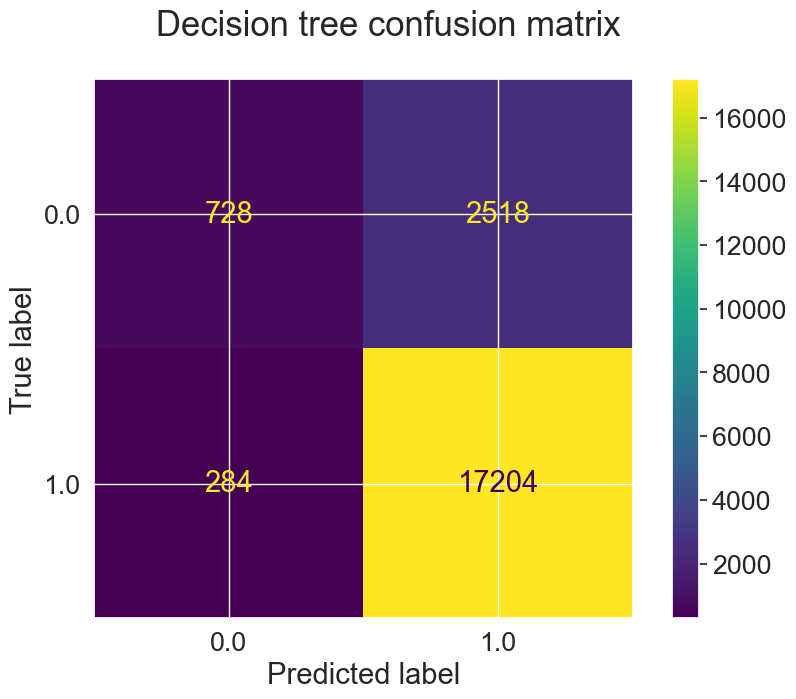

In [40]:
#Create confusion matrix
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale = 1.75)

y_test_pred = dt_clf_gridcv.best_estimator_.predict(X_test)
y_train_pred = dt_clf_gridcv.best_estimator_.predict(X_train)

cm = confusion_matrix(y_test, y_test_pred, labels = dt_clf_gridcv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                             display_labels = dt_clf_gridcv.best_estimator_.classes_)
disp.plot(ax = ax)
fig.suptitle('Decision tree confusion matrix', fontsize = 25)

plt.show()

In [41]:
#Comparing actual train data and predicted train data on decision tree model
print('Actual train data')
print(y_train[:100])
print('Predicted train data')
print(y_train_pred[:100])

Actual train data
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 1.]
Predicted train data
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [42]:
#Evaluate decision tree model accuracy
accuracy_training = accuracy_score(y_train,y_train_pred)
accuracy_test = accuracy_score(y_test,y_test_pred)

print(f'Decision tree model')
print(f'Accuracy Training Data: {accuracy_training}')
print(f'Accuracy Test Data: {accuracy_test}')

Decision tree model
Accuracy Training Data: 0.8626514740459396
Accuracy Test Data: 0.8648596508150863


In [43]:
#Classification report of previous model
print(f'Decision tree model')
print(classification_report(y_test, y_test_pred))

Decision tree model
              precision    recall  f1-score   support

         0.0       0.72      0.22      0.34      3246
         1.0       0.87      0.98      0.92     17488

    accuracy                           0.86     20734
   macro avg       0.80      0.60      0.63     20734
weighted avg       0.85      0.86      0.83     20734



In [44]:
from sklearn import tree

In [45]:
dt_clf = DecisionTreeClassifier(random_state=42,max_depth=3,min_samples_split = 400)

In [46]:
dt_clf.fit(X_test,y_test)

DecisionTreeClassifier(max_depth=3, min_samples_split=400, random_state=42)

In [47]:
fn = ['Delivery_arrival','Delivery_days','Payment_to_price']
cl = ('0','1')

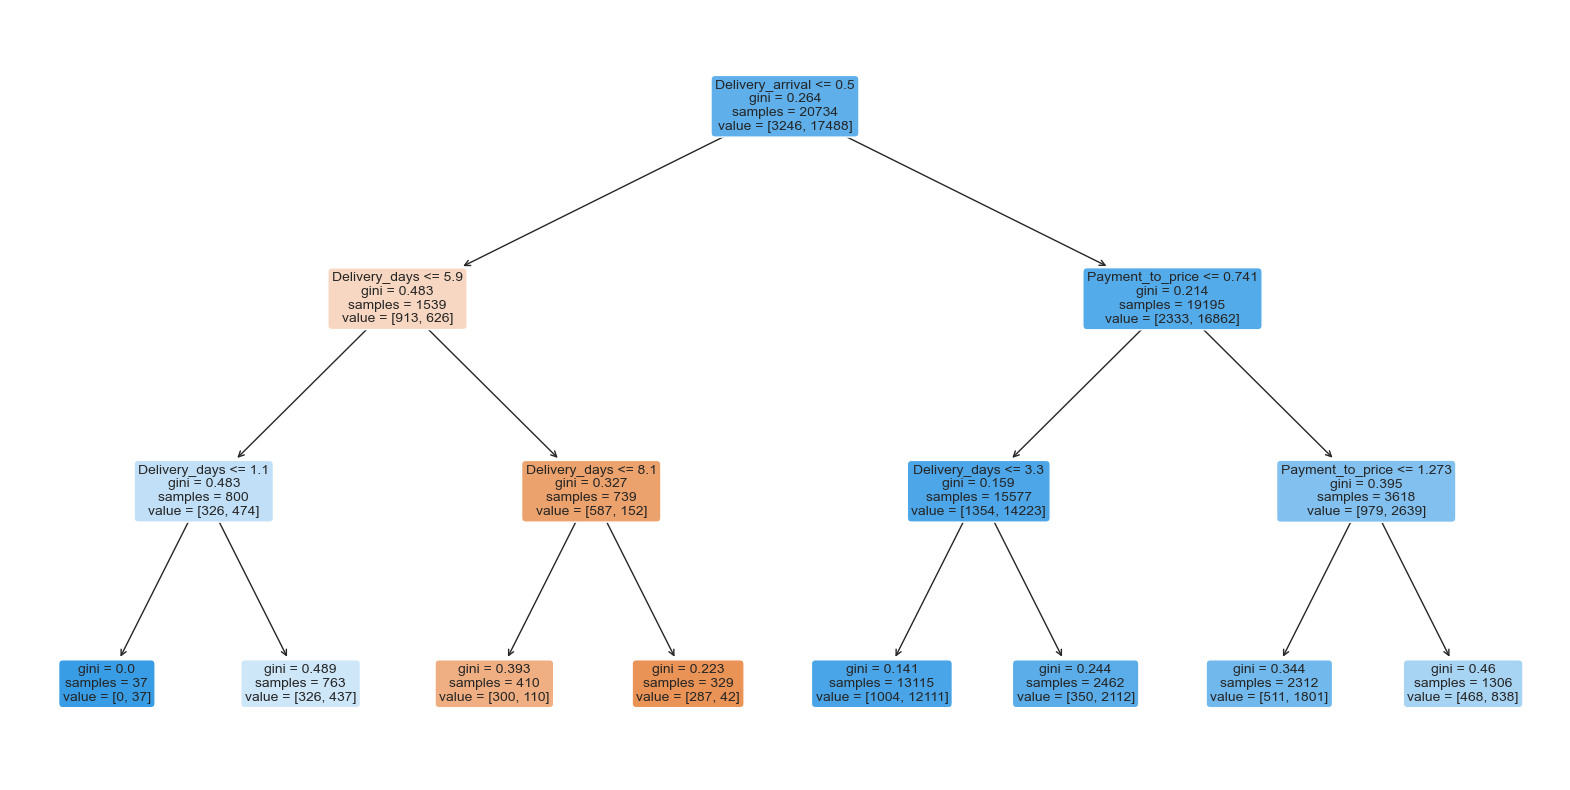

In [49]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.figure(figsize=(20,10))  # set plot size (denoted in inches)
plot_tree(dt_clf,feature_names=fn, fontsize=10, rounded=True, filled=True)
plt.show()